In [6]:
################ Mounting the Google Drive #################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Chargement et nettoyage initial

In [7]:
import pandas as pd
import numpy as np
import os, json, pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split

# Chargement
df = pd.read_csv('/content/drive/MyDrive/AIGRU/NIDataset.csv')

# Colonnes à retirer
to_drop = ['Flow_ID','Src_IP','Dst_IP','Timestamp','Src_Port','Dst_Port','Cat','Sub_Cat']
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# Colonnes constantes
nunique = df.nunique()
const_cols = nunique[nunique <= 1].index.tolist()
df.drop(columns=const_cols, inplace=True)

# Infini & NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)


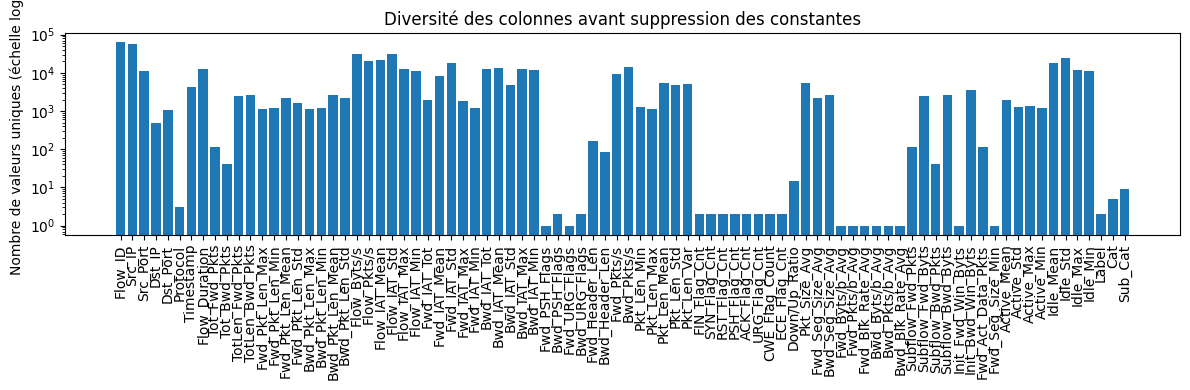

In [30]:

# 2. Nombre de valeurs uniques par colonne (pour visualiser les colonnes quasi-constantes)
uniques = df_raw.nunique()
plt.figure(figsize=(12,4))
plt.bar(uniques.index, uniques.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.ylabel("Nombre de valeurs uniques (échelle log)")
plt.title("Diversité des colonnes avant suppression des constantes")
plt.tight_layout()
plt.show()


# 2. Encodages (labels & protocoles)

In [8]:
# Label
label_le = LabelEncoder()
df['y'] = label_le.fit_transform(df['Label'])
df.drop(columns=['Label'], inplace=True)

# Protocol
df['Protocol'] = df['Protocol'].astype(str)
proto_le = LabelEncoder()
df['Protocol_enc'] = proto_le.fit_transform(df['Protocol'])
df.drop(columns=['Protocol'], inplace=True)


# 3. Suppression des colonnes trop corrélées

In [9]:
def remove_high_corr(df_, thresh=0.85):
    corr = df_.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [col for col in upper.columns if any(upper[col] > thresh)]
    return df_.drop(columns=drop), drop

features = [c for c in df.columns if c != 'y']
df_feats = df[features]
df_reduced, dropped_corr = remove_high_corr(df_feats)
print("Colonnes corrélées supprimées :", dropped_corr)


Colonnes corrélées supprimées : ['Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Max', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Var', 'PSH_Flag_Cnt', 'URG_Flag_Cnt', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Bwd_Seg_Size_Avg', 'Subflow_Fwd_Pkts', 'Subflow_Fwd_Byts', 'Subflow_Bwd_Pkts', 'Subflow_Bwd_Byts', 'Fwd_Act_Data_Pkts', 'Active_Max', 'Active_Min', 'Idle_Mean', 'Idle_Std', 'Idle_Max', 'Idle_Min']


## Matrice de corrélation avant suppression

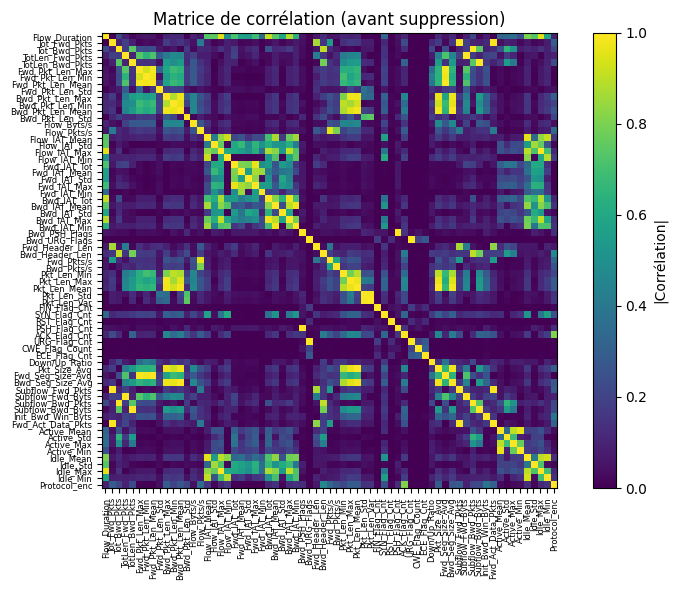

In [33]:
corr_full = df_feats.corr().abs()

plt.figure(figsize=(8,6))
plt.imshow(corr_full, vmin=0, vmax=1)
plt.colorbar(label='|Corrélation|')
ticks = np.arange(len(corr_full.columns))
plt.xticks(ticks, corr_full.columns, rotation=90, fontsize=6)
plt.yticks(ticks, corr_full.columns, fontsize=6)
plt.title('Matrice de corrélation (avant suppression)')
plt.tight_layout()
plt.show()


## Histogramme du nombre de corrélations fortes par colonne

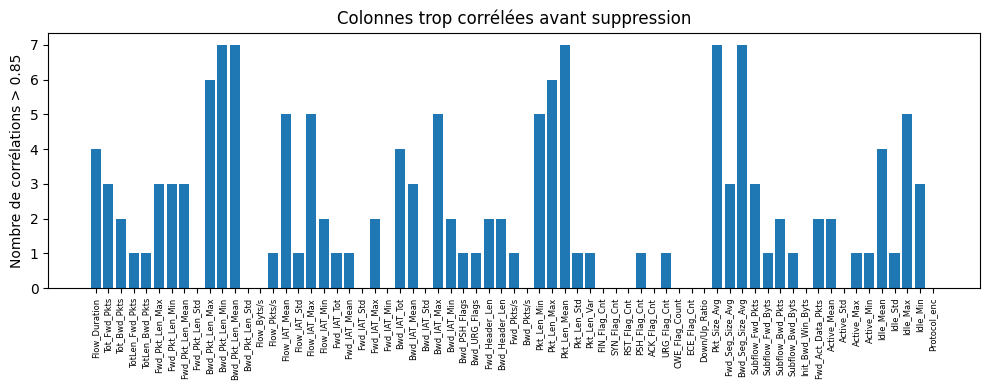

In [34]:
thresh = 0.85
# Pour chaque colonne, compter combien d’autres ont |corr|>thresh
high_corr_counts = (corr_full > thresh).sum(axis=0) - 1  # on retire la self-corr

plt.figure(figsize=(10,4))
plt.bar(high_corr_counts.index, high_corr_counts.values)
plt.xticks(rotation=90, fontsize=6)
plt.ylabel("Nombre de corrélations > 0.85")
plt.title("Colonnes trop corrélées avant suppression")
plt.tight_layout()
plt.show()



# 4. Normalisation et séquençage temporel

In [10]:
# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reduced)
y = df['y'].values

# Séquences
SEQ_LEN = 10
def create_sequences(X, y, L=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X)-L):
        Xs.append(X[i:i+L])
        ys.append(y[i+L-1])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y)
print("X_seq:", X_seq.shape, "y_seq:", y_seq.shape)


X_seq: (625773, 10, 33) y_seq: (625773,)


## Comparaison avant / après normalisation (1000 premiers échantillons)

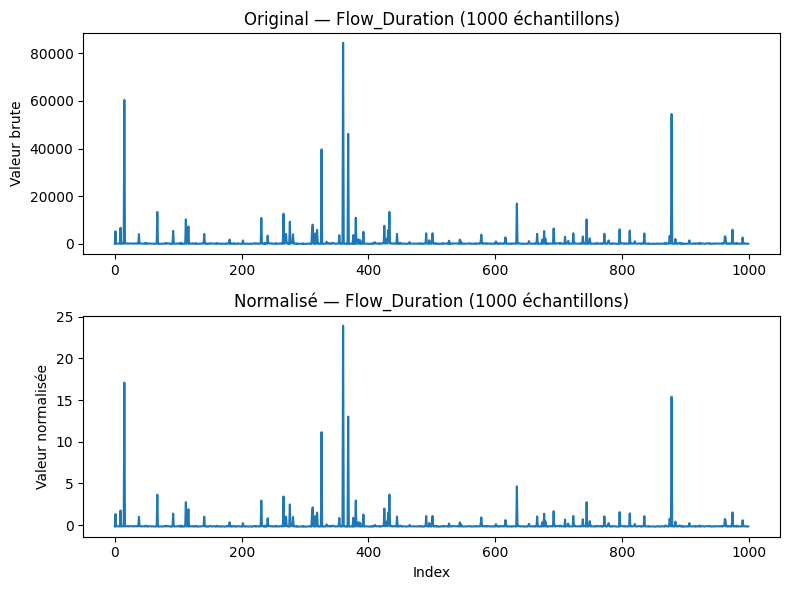

In [27]:
import matplotlib.pyplot as plt

# Choix de la feature à visualiser
feature_name = 'Flow_Duration'
feat_idx = df_reduced.columns.get_loc(feature_name)

orig_vals   = df_reduced.iloc[:1000, feat_idx].values
scaled_vals = X_scaled[:1000, feat_idx]

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(orig_vals)
plt.title(f'Original — {feature_name} (1000 échantillons)')
plt.ylabel('Valeur brute')

plt.subplot(2,1,2)
plt.plot(scaled_vals)
plt.title(f'Normalisé — {feature_name} (1000 échantillons)')
plt.xlabel('Index')
plt.ylabel('Valeur normalisée')

plt.tight_layout()
plt.show()


## Exemples de séquences créées (3 premières séquences)

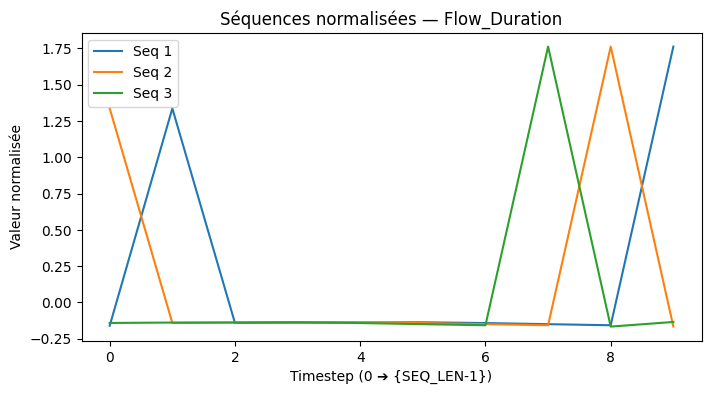

In [26]:
plt.figure(figsize=(8,4))

for i in range(3):
    plt.plot(X_seq[i, :, feat_idx], label=f'Seq {i+1}')

plt.title(f'Séquences normalisées — {feature_name}')
plt.xlabel('Timestep (0 ➔ {SEQ_LEN-1})')
plt.ylabel('Valeur normalisée')
plt.legend()
plt.show()


# 5. Équilibrage et split train/test

In [11]:
# Upsampling
cnt = Counter(y_seq)
minor = 1 if cnt[1]<cnt[0] else 0
mi_idx = np.where(y_seq==minor)[0]
ma_idx = np.where(y_seq!=minor)[0]
factor = len(ma_idx)//len(mi_idx)-1
X_up = np.repeat(X_seq[mi_idx], factor, axis=0)
y_up = np.repeat(y_seq[mi_idx], factor, axis=0)
X_bal = np.vstack([X_seq, X_up])
y_bal = np.hstack([y_seq, y_up])
print("Après upsampling :", Counter(y_bal))

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)


Après upsampling : Counter({np.int64(0): 585700, np.int64(1): 561022})


## Comptage avant et après upsampling

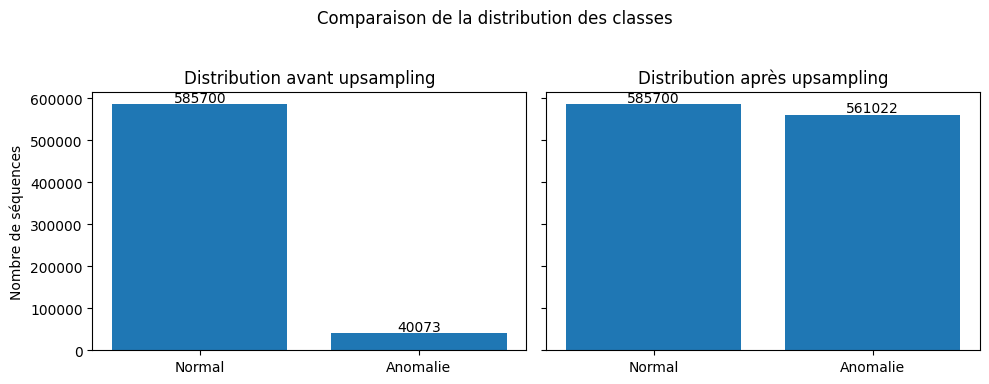

In [28]:

counts_before = Counter(y_seq)
counts_after  = Counter(y_bal)

labels = ['Normal', 'Anomalie']
vals_before = [counts_before[0], counts_before[1]]
vals_after  = [counts_after[0],  counts_after[1]]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Avant upsampling
axes[0].bar(labels, vals_before)
axes[0].set_title('Distribution avant upsampling')
axes[0].set_ylabel('Nombre de séquences')

# Après upsampling
axes[1].bar(labels, vals_after)
axes[1].set_title('Distribution après upsampling')

for ax in axes:
    for i, v in enumerate([vals_before, vals_after][axes.tolist().index(ax)]):
        ax.text(i, v + max(vals_after)*0.01, str(v), ha='center')

plt.suptitle('Comparaison de la distribution des classes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 6. Sauvegardes pour déploiement

In [12]:
save_path = '/content/drive/MyDrive/AIGRU/deployment'
os.makedirs(save_path, exist_ok=True)

# features.json
features_list = df_reduced.columns.tolist()
with open(os.path.join(save_path,'features.json'),'w') as f:
    json.dump({
        'feature_columns': features_list,
        'sequence_length': SEQ_LEN,
        'feature_dim': len(features_list)
    }, f, indent=4)

# scaler & encodeurs
with open(os.path.join(save_path,'scaler.pkl'),'wb') as f:
    pickle.dump(scaler, f)
with open(os.path.join(save_path,'label_encoder.pkl'),'wb') as f:
    pickle.dump(label_le, f)
with open(os.path.join(save_path,'protocol_encoder.pkl'),'wb') as f:
    pickle.dump(proto_le, f)

# test_input.json
test_input = {
    'sequences': X_seq[:20].tolist(),
    'sequence_length': SEQ_LEN,
    'feature_dim': X_seq.shape[2]
}
with open(os.path.join(save_path,'test_input.json'),'w') as f:
    json.dump(test_input, f)

print("Prétraitement et sauvegardes terminés.")


Prétraitement et sauvegardes terminés.


# 7. Résumé des données (tableau)

In [13]:
import pandas as pd
summary = pd.DataFrame({
    'Split':        ['Total','Train','Test'],
    'Séquences':    [X_seq.shape[0], X_train.shape[0], X_test.shape[0]],
    'Longueur seq': [SEQ_LEN]*3,
    'Feature dim':  [X_seq.shape[2]]*3,
    'Classe 0':     [np.sum(y_seq==0), np.sum(y_train==0), np.sum(y_test==0)],
    'Classe 1':     [np.sum(y_seq==1), np.sum(y_train==1), np.sum(y_test==1)],
})
print("\n=== Résumé des datasets ===")
print(summary.to_string(index=False))
print(f"\nFeatures retenues : {df_reduced.shape[1]}")
print(df_reduced.columns.tolist())



=== Résumé des datasets ===
Split  Séquences  Longueur seq  Feature dim  Classe 0  Classe 1
Total     625773            10           33    585700     40073
Train     917377            10           33    468560    448817
 Test     229345            10           33    117140    112205

Features retenues : 33
['Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Min', 'Bwd_IAT_Std', 'Bwd_PSH_Flags', 'Bwd_URG_Flags', 'Bwd_Pkts/s', 'Pkt_Len_Std', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'CWE_Flag_Count', 'ECE_Flag_Cnt', 'Down/Up_Ratio', 'Init_Bwd_Win_Byts', 'Active_Mean', 'Active_Std', 'Protocol_enc']


# 8. Construction et entraînement du modèle GRU

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.random.set_seed(42)
DEPLOY = '/content/drive/MyDrive/AIGRU/deployment'

with open(os.path.join(DEPLOY,'features.json')) as f:
    feat = json.load(f)
seq_length, feature_dim = feat['sequence_length'], feat['feature_dim']

def build_gru(seq_len, feat_dim):
    m = Sequential([
        GRU(128, input_shape=(seq_len, feat_dim), return_sequences=True),
        Dropout(0.3),
        GRU(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
    return m

model = build_gru(seq_length, feature_dim)
ckpt = os.path.join(DEPLOY,'gru_model.keras')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1,        # ajuste selon convergence
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)
model.save(ckpt)
print("Modèle entraîné et sauvegardé dans", ckpt)


11468/11468 - 263s - 23ms/step - accuracy: 0.9264 - auc: 0.9789 - loss: 0.1841 - precision: 0.9293 - recall: 0.9197 - val_accuracy: 0.9537 - val_auc: 0.9900 - val_loss: 0.1221 - val_precision: 0.9463 - val_recall: 0.9597
Modèle entraîné et sauvegardé dans /content/drive/MyDrive/AIGRU/deployment/gru_model.keras


# 9. Évaluation brute & rapport classification

In [18]:
from sklearn.metrics import classification_report

# Évaluation
results = model.evaluate(X_test, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, results)))

# Classification report
y_prob = model.predict(X_test, verbose=0).flatten()
y_pred = (y_prob > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal','Anomalie']))


Test metrics: {'loss': 0.12296908348798752, 'compile_metrics': 0.9532625675201416}

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.95    117140
    Anomalie       0.95      0.96      0.95    112205

    accuracy                           0.95    229345
   macro avg       0.95      0.95      0.95    229345
weighted avg       0.95      0.95      0.95    229345



# 10. Matrice de confusion (visualisation)

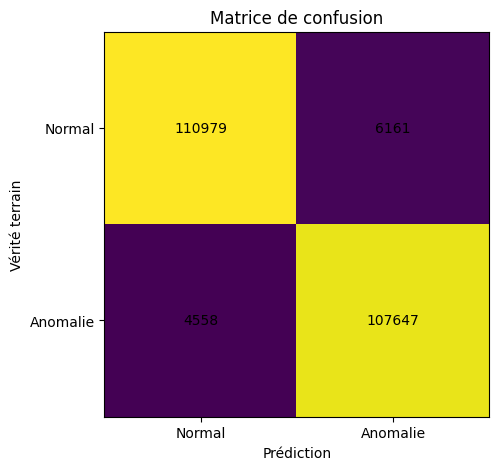

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.xticks([0,1], ['Normal','Anomalie'])
plt.yticks([0,1], ['Normal','Anomalie'])
plt.title('Matrice de confusion')
plt.show()


# 11. Analyse des courbes ROC et études comparatives

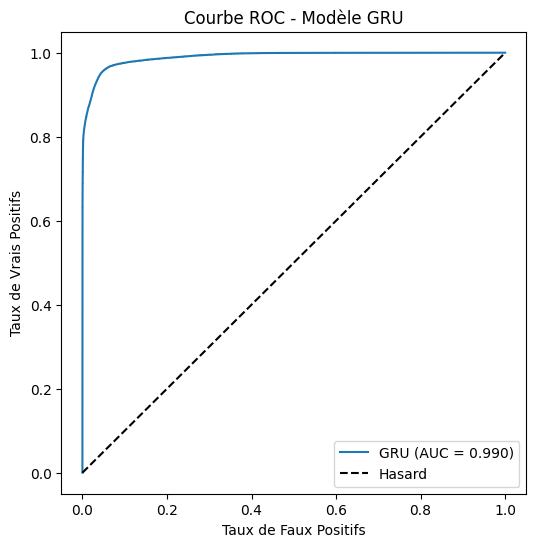

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. ROC pour le modèle GRU
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'GRU (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Hasard')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Modèle GRU')
plt.legend(loc='lower right')
plt.show()


# 12. Test de bout en bout avec test_input.json

In [21]:
import tensorflow as tf

# Charger modèle
model = tf.keras.models.load_model(os.path.join(DEPLOY,'gru_model.keras'))
print("Modèle chargé")

# Charger séquences
with open(os.path.join(DEPLOY,'test_input.json'),'r') as f:
    test_data = json.load(f)
sequences = np.array(test_data['sequences'])
print("Séquences chargées:", sequences.shape)

# Prédictions & affichage
probs = model.predict(sequences, verbose=0).flatten()
preds = (probs > 0.5).astype(int)
for idx, (p, c) in enumerate(zip(probs, preds), 1):
    print(f"Séq {idx}: prob={p:.4f} →", 'Anomalie' if c else 'Normal')
print("Test de bout en bout réussi.")


Modèle chargé
Séquences chargées: (20, 10, 33)
Séq 1: prob=0.0000 → Normal
Séq 2: prob=0.0518 → Normal
Séq 3: prob=0.0015 → Normal
Séq 4: prob=0.9705 → Anomalie
Séq 5: prob=0.0009 → Normal
Séq 6: prob=0.0001 → Normal
Séq 7: prob=0.0000 → Normal
Séq 8: prob=0.0000 → Normal
Séq 9: prob=0.7837 → Anomalie
Séq 10: prob=0.0009 → Normal
Séq 11: prob=0.0336 → Normal
Séq 12: prob=0.0003 → Normal
Séq 13: prob=0.0123 → Normal
Séq 14: prob=0.6992 → Anomalie
Séq 15: prob=0.0003 → Normal
Séq 16: prob=0.0578 → Normal
Séq 17: prob=0.0001 → Normal
Séq 18: prob=0.0011 → Normal
Séq 19: prob=0.0001 → Normal
Séq 20: prob=0.0608 → Normal
Test de bout en bout réussi.
